1. Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

2. Check GPU

In [2]:
cuda = torch.cuda.is_available()
print(f"CUDA Available: {cuda}")

random_seed = 21
torch.manual_seed(random_seed)
if cuda:
    torch.cuda.manual_seed(random_seed)

CUDA Available: True


3. Create transformations

In [3]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

# Test data transformations. Use same mean and std as train set
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1407,), (0.4081,))
    transforms.Normalize((0.1307,), (0.3081,)),
])

4. Get train and test data

In [4]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:12<00:00, 817851.07it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 94165.26it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:07<00:00, 214596.25it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 2112500.42it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



5. Create data loaders

In [5]:
batch_size = 128
# batch_size=256
# kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True}
kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

6. Plot some data

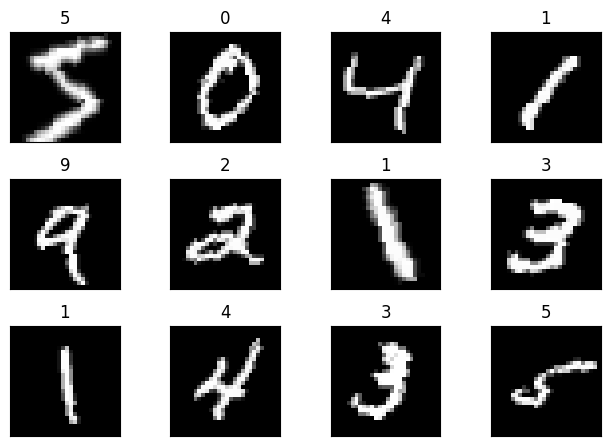

In [6]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])


7. Create the model

In [7]:
class Net(nn.Module):
    # Define the structure of the NN

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv4 = nn.Conv2d(32, 8, kernel_size=1)
        # -> maxpooling
        self.conv5 = nn.Conv2d(8, 16, kernel_size=3)
        self.conv6 = nn.Conv2d(16, 16, kernel_size=3)
        self.fc1 = nn.Linear(784, 10)

    def forward(self, x):
        # 1 x 1 should be before maxpooling, not after -- compress original features better
        # relu after maxpooling, or relu before maxpooling have same output

        x = F.relu(self.conv1(x), 2)    # 512 x 8 x 26 x 26
        x = F.relu(self.conv2(x), 2)    # 512 x 16 x 24 x 24
        x = F.relu(self.conv3(x))       # 512 x 32 x 22 x 22
        x = self.conv4(x)               # 512 x 8 x 22 x 22
        # print(f"After conv4: {x.shape}")
        x = F.relu(F.max_pool2d(x, 2))  # 512 x 8 x 11 x 11

        x = F.relu(self.conv5(x))  # 512 x 16 x 9 x 9
        x = F.relu(self.conv6(x))  # 512 x 32 x 7 x 7
        # print(f"After conv6: {x.shape}")
        x = x.view(-1, 784)
        x = self.fc1(x)
        return x


8. Model Summary

In [8]:
from torchsummary import summary

device = "cuda" if cuda else "cpu"
model = Net().to(device)

summary(model, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
            Conv2d-2           [-1, 16, 24, 24]           1,168
            Conv2d-3           [-1, 32, 22, 22]           4,640
            Conv2d-4            [-1, 8, 22, 22]             264
            Conv2d-5             [-1, 16, 9, 9]           1,168
            Conv2d-6             [-1, 16, 7, 7]           2,320
            Linear-7                   [-1, 10]           7,850
Total params: 17,490
Trainable params: 17,490
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.28
Params size (MB): 0.07
Estimated Total Size (MB): 0.34
----------------------------------------------------------------


9. Initializing variables

In [9]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

10. Train and test functions

In [10]:
from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
    model.train()
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        # Predict
        pred = model(data)

        # Calculate loss
        # print(f"Prediction: {pred}, target={target}")
        loss = criterion(pred, target)
        train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        correct += GetCorrectPredCount(pred, target)
        processed += len(data)

        pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_acc.append(100 * correct / processed)
    train_losses.append(train_loss / len(train_loader))


def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            # test_loss += criterion(output, target, reduction='sum').item() # Sum up batch loss
            test_loss += criterion(output, target).item() # Sum up batch loss

            correct += GetCorrectPredCount(output, target)

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


11. Train the model

In [11]:
device = "cuda" if cuda else "cpu"
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

criterion = nn.CrossEntropyLoss(reduction='mean')
num_epochs = 20

for epoch in range(1, num_epochs+1):
    print(f"Epoch {epoch}")
    train(model, device, train_loader, optimizer, criterion)
    test(model, device, test_loader, criterion)
    scheduler.step()

Epoch 1


Train: Loss=0.1993 Batch_id=468 Accuracy=72.54: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 84.29it/s]


Test set: Average loss: 0.0010, Accuracy: 9598/10000 (95.98%)

Epoch 2


Train: Loss=0.2964 Batch_id=468 Accuracy=95.45: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 89.32it/s]


Test set: Average loss: 0.0005, Accuracy: 9789/10000 (97.89%)

Epoch 3


Train: Loss=0.2563 Batch_id=468 Accuracy=96.65: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 89.12it/s]


Test set: Average loss: 0.0004, Accuracy: 9836/10000 (98.36%)

Epoch 4


Train: Loss=0.2872 Batch_id=468 Accuracy=97.11: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 87.63it/s]


Test set: Average loss: 0.0003, Accuracy: 9856/10000 (98.56%)

Epoch 5


Train: Loss=0.2403 Batch_id=468 Accuracy=97.46: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 87.56it/s]


Test set: Average loss: 0.0003, Accuracy: 9837/10000 (98.37%)

Epoch 6


Train: Loss=0.2443 Batch_id=468 Accuracy=97.74: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 91.67it/s]


Test set: Average loss: 0.0003, Accuracy: 9871/10000 (98.71%)

Epoch 7


Train: Loss=0.2126 Batch_id=468 Accuracy=97.79: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 89.62it/s]


Test set: Average loss: 0.0003, Accuracy: 9857/10000 (98.57%)

Epoch 8


Train: Loss=0.2968 Batch_id=468 Accuracy=98.17: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 90.72it/s]


Test set: Average loss: 0.0003, Accuracy: 9888/10000 (98.88%)

Epoch 9


Train: Loss=0.2603 Batch_id=468 Accuracy=98.14: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 89.69it/s]


Test set: Average loss: 0.0002, Accuracy: 9902/10000 (99.02%)

Epoch 10


Train: Loss=0.2094 Batch_id=468 Accuracy=98.27: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 91.10it/s]


Test set: Average loss: 0.0002, Accuracy: 9904/10000 (99.04%)

Epoch 11


Train: Loss=0.3001 Batch_id=468 Accuracy=98.34: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 89.48it/s]


Test set: Average loss: 0.0003, Accuracy: 9886/10000 (98.86%)

Epoch 12


Train: Loss=0.2091 Batch_id=468 Accuracy=98.50: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 90.16it/s]


Test set: Average loss: 0.0002, Accuracy: 9903/10000 (99.03%)

Epoch 13


Train: Loss=0.2549 Batch_id=468 Accuracy=98.56: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 89.62it/s]


Test set: Average loss: 0.0002, Accuracy: 9907/10000 (99.07%)

Epoch 14


Train: Loss=0.1887 Batch_id=468 Accuracy=98.51: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 89.26it/s]


Test set: Average loss: 0.0002, Accuracy: 9901/10000 (99.01%)

Epoch 15


Train: Loss=0.2347 Batch_id=468 Accuracy=98.62: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 89.00it/s]


Test set: Average loss: 0.0003, Accuracy: 9897/10000 (98.97%)

Epoch 16


Train: Loss=0.2230 Batch_id=468 Accuracy=98.89: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 86.74it/s]


Test set: Average loss: 0.0002, Accuracy: 9929/10000 (99.29%)

Epoch 17


Train: Loss=0.1982 Batch_id=468 Accuracy=98.96: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 92.33it/s]


Test set: Average loss: 0.0002, Accuracy: 9929/10000 (99.29%)

Epoch 18


Train: Loss=0.2336 Batch_id=468 Accuracy=98.98: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 92.54it/s]


Test set: Average loss: 0.0002, Accuracy: 9925/10000 (99.25%)

Epoch 19


Train: Loss=0.2208 Batch_id=468 Accuracy=98.98: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 90.72it/s]


Test set: Average loss: 0.0002, Accuracy: 9925/10000 (99.25%)

Epoch 20


Train: Loss=0.2066 Batch_id=468 Accuracy=99.01: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:05<00:00, 89.97it/s]


Test set: Average loss: 0.0002, Accuracy: 9919/10000 (99.19%)



12. Train/Test loss and accuracy plots

Text(0.5, 1.0, 'Test Accuracy')

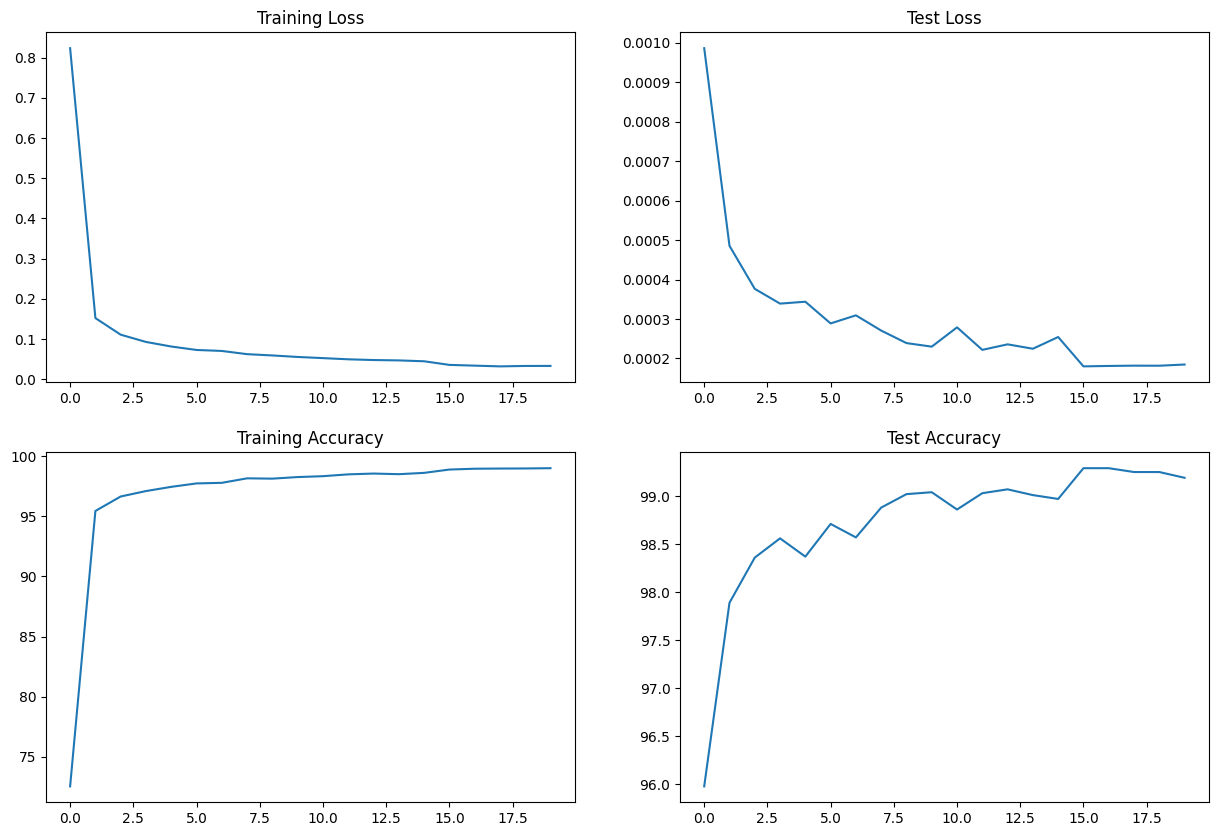

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")